# 1- Diffusion problem with zero boundary conditions


We want to solve:
$$
\begin{align*}
    -\Delta u &= f(x,y)\\
    u(x,y) &=0 \quad \forall x  \forall y  \in \partial \Omega
\end{align*}
$$
We set u = $(1-x^2)(1-y^2)$ the exact solution in order to find f(x,y)
$$
\begin{align*}
    u(x, y) &= (1-x^2)(1-y^2) \\
    &= 1 -y^2 -x^2(1-y^2) \\
\end{align*}
\newline
\begin{align*}
    \frac{\partial u}{\partial x}(x, y) = -2x(1-y^2) \\
\end{align*}
\newline
\begin{align*}
    \frac{\partial^2u}{\partial x^2}(x,y) = -2(1-y^2)
\end{align*}
$$
So, we want to solve the following problem:
$$
\begin{align*}
    -\Delta u &= 2(1-y^2) + 2(1-x^2)\\
    u(x,y) &=0 \quad \forall x  \forall y  \in \partial \Omega
\end{align*}
$$
We are going to minimise:
$$
\begin{align*}
    L = \frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dx dy + \int_\Omega f(x,y)u(x,y)dx dy - \beta \frac{1}{N_{boundary}}\sum_{i=0}^{N_{boundary}}(u(x_i, y_i) - \hat{u}(x_i, y_i))^2
\end{align*}
$$
The advantage of this manufactured example is that we can compute exactly each term of the loss and know if we approximate it correctly:
$$
\begin{align*}
    \frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dx dy &= \frac{1}{2}\int_{-1}^{1}\int_{-1}^{1}4x^2(1-y^2)^2dxdy \\
    &= \frac{128}{45}
\end{align*}
$$
$$
\begin{align*}
    \int_\Omega f(x,y)u(x,y)dx dy &= \frac{1}{2}\int_{-1}^{1}\int_{-1}^{1}(2(1-y^2)+2(1-x^2))(1-x^2)(1-y^2)dxdy \\
    &= \frac{256}{45}
\end{align*}
$$

In [1]:
import dolfin
import sys, os
import torch
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from NeuralNetworks import fwdNN as fwd
from NeuralNetworks import residualNN as rnn

Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class DeepRitzLoss(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, x_omega, ux_omega, fx, ux_boundary, cl_boundary, reg_boundary=500):
        grad_u = torch.autograd.grad(inputs=x_omega, outputs=ux_omega, grad_outputs=torch.ones_like(ux_omega), create_graph=True)[0]
        grad_ux1, grad_ux2 = grad_u[:, 0], grad_u[:, 1]
        
        physical_term1 = grad_ux1.pow(2) + grad_ux2.pow(2)
        physical_term2 = fx*ux_omega
        boundary_term = (cl_boundary - ux_boundary).pow(2)

        loss_term1 = 4/2*physical_term1.mean()
        loss_term2 = 4*physical_term2.mean()
        loss_term3 = boundary_term.mean()
        loss = loss_term1 - loss_term2 + reg_boundary*loss_term3

        return loss, loss_term1, loss_term2, loss_term3
    
class Omega2D(Dataset):
    def __init__(self, n_omega=100, n_boundary=75, x_bounds=[-1, 1], y_bounds=[-1, 1]):

        self.n_omega = n_omega
        self.n_boundary = n_boundary
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds

        self.omega_train, self.boundary_train = self._create_points_for_training()
        self.mesh_eval = self._create_points_for_evaluation()

    def _create_points_for_training(self):
        xmin, xmax = self.x_bounds
        ymin, ymax = self.y_bounds

        x = np.random.uniform(xmin, xmax, self.n_omega)
        y = np.random.uniform(ymin, ymax, self.n_omega)
        omega_coordinates = np.column_stack((x, y))

        n_per_boundary = self.n_boundary//4
        x_left, y_left = xmin*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_right, y_right = xmax*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_bottom, y_bottom = np.random.uniform(xmin, xmax, n_per_boundary), ymin*np.ones(n_per_boundary)
        x_top, y_top = np.random.uniform(xmin, xmax, n_per_boundary), ymax*np.ones(n_per_boundary)
        x_boundary = np.concatenate((x_left, x_right, x_bottom, x_top))
        y_boundary = np.concatenate((y_left, y_right, y_bottom, y_top))
        boundary_coordinates = np.column_stack((x_boundary, y_boundary))

        return omega_coordinates, boundary_coordinates
    
    def _create_points_for_evaluation(self):
        mesh = dolfin.RectangleMesh(dolfin.Point(self.x_bounds[0], self.y_bounds[0]), dolfin.Point(self.x_bounds[1], self.y_bounds[1]), 100, 100)
        mesh_coordinates = mesh.coordinates()

        return np.array(mesh_coordinates)

    def plot(self):
        plt.scatter(self.omega_train[:, 0], self.omega_train[:, 1], c='blue', alpha=0.6, label='Omega points')
        plt.scatter(self.boundary_train[:, 0], self.boundary_train[:, 1], c='red', alpha=0.6, label='Boundary points')
        plt.title('Domain with corner singularity along the x-axis at y=0')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

In [20]:
class ExampleOne():
    def __init__(self, hidden_size=20):
        
        self.model = fwd.FullyConnectedNetwork(input_dim=2, hidden_size=hidden_size).to(device)
        # self.model = RitzModel(input_dim=2, num_blocks=4, hidden_size=hidden_size)
        self.criterion = DeepRitzLoss()

        self.total_loss = []
        self.physical_loss1 = []
        self.physical_loss2 = []
        self.boundary_loss = []

    def train(self, n_iter):

        criterion = self.criterion
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.model.train()

        for iter_i in range(n_iter):
            integration_grid = Omega2D(10000, 2500)

            x_omega = torch.FloatTensor(integration_grid.omega_train).to(device)
            x_boundary = torch.FloatTensor(integration_grid.boundary_train).to(device)
            fx_omega = (torch.FloatTensor(self.f(x_omega.cpu())).unsqueeze(1)).to(device)
            cl_boundary = self.cl_boundary(x_boundary).to(device)
            x_omega.requires_grad = True

            model_optimizer.zero_grad()
            ux_omega = self.model(x_omega)
            ux_boundary = self.model(x_boundary)
            loss, physical_loss1, physical_loss2, boundary_loss = criterion(x_omega, ux_omega, fx_omega, ux_boundary, cl_boundary)

            self.total_loss.append(loss.item())
            self.physical_loss1.append(physical_loss1.item())
            self.physical_loss2.append(physical_loss2.item())
            self.boundary_loss.append(boundary_loss.item())

            loss.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iteration {iter_i}, loss: {loss.item()}')

    def cl_boundary(self, x):
        return torch.zeros(x.shape[0], 1)
    
    def f(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        fx = 2*(1-x2**2) + 2*(1-x1**2)
        return fx
    
    def u(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        u = (1-x1**2)*(1-x2**2)
        return u

def asses_solution(example):
    model = example.model
    model.eval()

    evaluation_grid = Omega2D()
    x_eval = torch.FloatTensor(evaluation_grid.mesh_eval).to(device)

    u_pred = (model(x_eval).cpu().detach().numpy()).reshape(101, 101)
    u_exact = (example.u(x_eval).cpu().numpy()).reshape(101, 101)

    print(np.mean(np.abs(u_exact-u_pred)))
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axes[0].imshow(u_pred, cmap='jet', extent=[-1, 1, -1, 1], interpolation='bicubic')
    axes[0].set_title('Predicted solution')
    fig.colorbar(im0, ax=axes[0], shrink=0.6)

    im1 = axes[1].imshow(u_exact, cmap='jet', extent=[-1, 1, -1, 1], interpolation='bicubic')
    axes[1].set_title('Exact solution')
    fig.colorbar(im1, ax=axes[1], shrink=0.6)

    plt.show()

In [10]:
torch.manual_seed(15)

In [11]:
model1 = ExampleOne(hidden_size=20)
model1.train(5000)

Iteration 0, loss: 16.767955780029297
Iteration 100, loss: -0.06560076028108597
Iteration 200, loss: -0.0705154538154602
Iteration 300, loss: -0.0821918249130249
Iteration 400, loss: -0.10428397357463837
Iteration 500, loss: -0.15386073291301727
Iteration 600, loss: -0.26331692934036255
Iteration 700, loss: -0.6755932569503784
Iteration 800, loss: -2.4581010341644287
Iteration 900, loss: -2.7463879585266113
Iteration 1000, loss: -2.7079176902770996
Iteration 1100, loss: -2.7869255542755127
Iteration 1200, loss: -2.785386323928833
Iteration 1300, loss: -2.733458995819092
Iteration 1400, loss: -2.833414077758789
Iteration 1500, loss: -2.769739866256714
Iteration 1600, loss: -2.8664815425872803
Iteration 1700, loss: -2.756377935409546
Iteration 1800, loss: -2.8559155464172363
Iteration 1900, loss: -2.837639093399048
Iteration 2000, loss: -2.757143497467041
Iteration 2100, loss: -2.866466522216797
Iteration 2200, loss: -2.8221399784088135
Iteration 2300, loss: -2.8381688594818115
Iteration

5.688888888888889


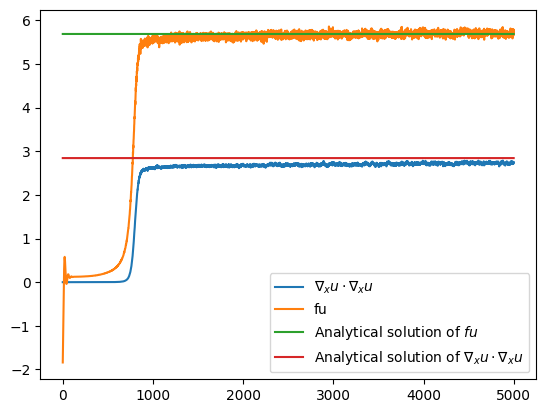

In [12]:
plt.plot(model1.physical_loss1, label=r'$\nabla_x u \cdot \nabla_x u$')
plt.plot(model1.physical_loss2, label=r'fu')
plt.plot(np.ones(len(model1.physical_loss2))*256/45, label=r'Analytical solution of $fu$')
plt.plot(np.ones(len(model1.physical_loss1))*128/45, label=r'Analytical solution of $\nabla_x u \cdot \nabla_x u$')
plt.legend()
print(256/45)

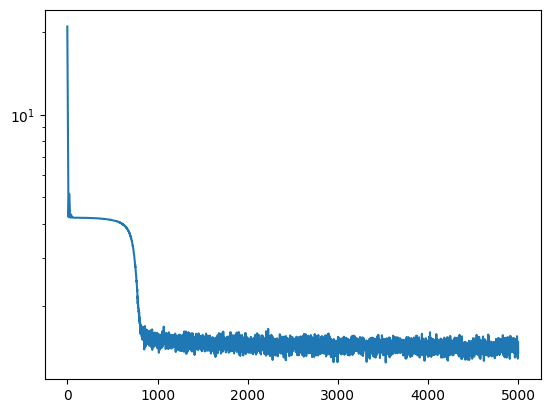

In [13]:
total_loss = model1.total_loss
plt.plot(np.array(total_loss) - 64/45 + 256/45, label='Total loss')
plt.yscale('log')
plt.show()

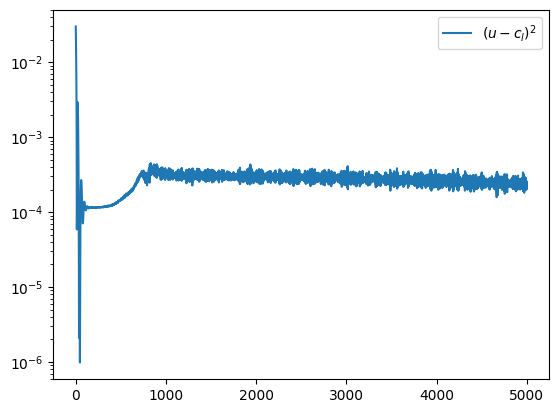

In [14]:
plt.plot(model1.boundary_loss, label=r'$(u - c_l)^2$')
plt.yscale('log')
plt.legend()

0.0061962865


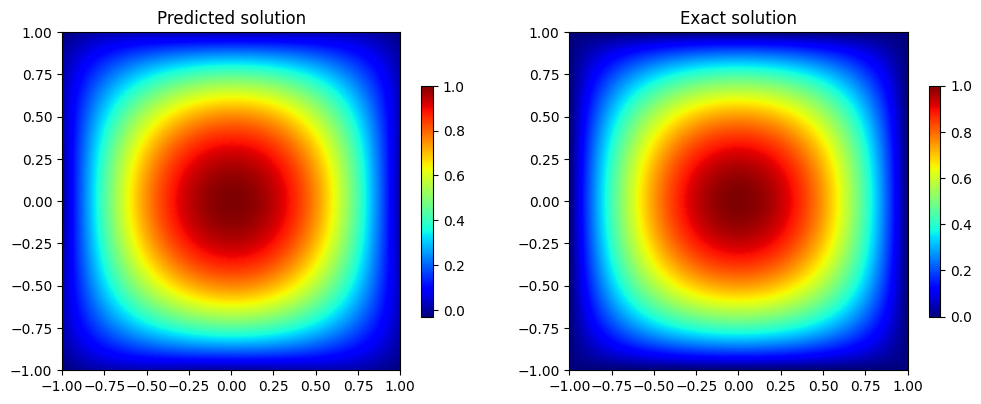

In [21]:
asses_solution(model1)